# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Get Data

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

The `assets.h5` store can be generated using the the notebook [create_datasets](../data/create_datasets.ipynb) in the [data](../data) directory in the root directory of this repo for instruction to download the following dataset.

Set data store location:

In [5]:
DATA_STORE = '../data/assets.h5'

In [6]:
DATA_STORE

'../data/assets.h5'

In [7]:
START = 2000
END = 2018

In [8]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    #stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]

In [9]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


In [10]:
stocks.info()

NameError: name 'stocks' is not defined

### Keep data with stock info

Remove `stocks` duplicates and align index names for later joining.

In [9]:
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

Get tickers with both price information and metdata

In [10]:
shared = prices.columns.intersection(stocks.index)

In [11]:
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2412 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2407 non-null   float64
 1   ipoyear    1065 non-null   float64
 2   sector     2372 non-null   object 
dtypes: float64(2), object(1)
memory usage: 75.4+ KB


In [12]:
prices = prices.loc[:, shared]
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 86.6 MB


In [13]:
assert prices.shape[1] == stocks.shape[0]

## Create monthly return series

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [9]:
monthly_prices = prices.resample('M').last()

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [10]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: ME
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 5.3 MB


In [11]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 521806 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   521806 non-null  float64
 1   return_2m   521806 non-null  float64
 2   return_3m   521806 non-null  float64
 3   return_6m   521806 non-null  float64
 4   return_9m   521806 non-null  float64
 5   return_12m  521806 non-null  float64
dtypes: float64(6)
memory usage: 26.0+ MB


## Drop stocks with less than 10 yrs of returns

In [12]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   465935 non-null  float64
 1   return_2m   465935 non-null  float64
 2   return_3m   465935 non-null  float64
 3   return_6m   465935 non-null  float64
 4   return_9m   465935 non-null  float64
 5   return_12m  465935 non-null  float64
dtypes: float64(6)
memory usage: 23.3+ MB


In [13]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,465935.000000,465935.000000,465935.000000,465935.000000,465935.000000,465935.000000
mean,0.011694,0.008454,0.007306,0.006036,0.005542,0.005285
std,0.117872,0.084059,0.069195,0.050674,0.041919,0.036635
min,-0.343442,-0.269341,-0.229978,-0.175426,-0.145071,-0.125787
25%,-0.046679,-0.031096,-0.024413,-0.015632,-0.012035,-0.009962
50%,0.006369,0.007476,0.007810,0.008024,0.007924,0.007852
75%,0.065314,0.048890,0.041722,0.031742,0.027062,0.024439
max,0.449446,0.294075,0.230064,0.159207,0.128147,0.108809


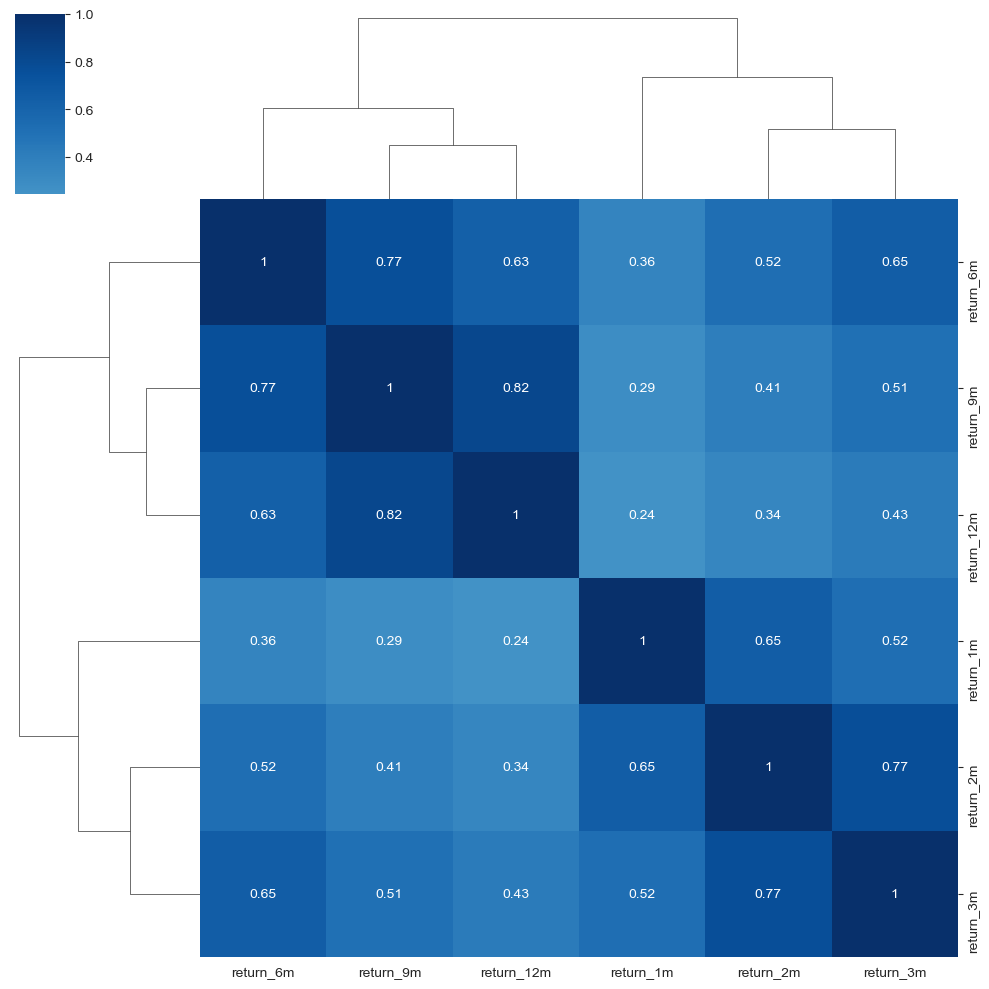

In [14]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

We are left with 1,670 tickers.

In [20]:
data.index.get_level_values('ticker').nunique()

1838

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 9, Time Series Models](../09_time_series_models).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `RollingOLS` rolling linear regression functionality in the `statsmodels` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [15]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 292 entries, 2000-01-31 to 2024-04-30
Freq: ME
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  292 non-null    float64
 1   SMB     292 non-null    float64
 2   HML     292 non-null    float64
 3   RMW     292 non-null    float64
 4   CMA     292 non-null    float64
dtypes: float64(5)
memory usage: 13.7 KB


In [16]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     465935 non-null  float64
 1   SMB        465935 non-null  float64
 2   HML        465935 non-null  float64
 3   RMW        465935 non-null  float64
 4   CMA        465935 non-null  float64
 5   return_1m  465935 non-null  float64
dtypes: float64(6)
memory usage: 23.3+ MB


In [17]:
T = 24
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [18]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,411080.000000,411080.000000,411080.000000,4.110800e+05,411080.000000,465935.000000
mean,0.973495,0.636984,0.114762,-9.591587e-02,0.011063,1.447263
std,0.950564,1.299706,1.665761,1.970654e+00,2.250554,3.417190
min,-9.839232,-10.501530,-15.440012,-2.388501e+01,-20.177240,-34.475140
25%,0.429071,-0.118705,-0.727268,-1.038776e+00,-1.110391,0.000000
50%,0.918570,0.541594,0.073645,2.617536e-15,0.017213,1.123798
75%,1.458626,1.331304,0.948243,9.434992e-01,1.153638,3.149547
max,10.965766,10.437477,16.273464,1.894054e+01,21.483337,39.249219


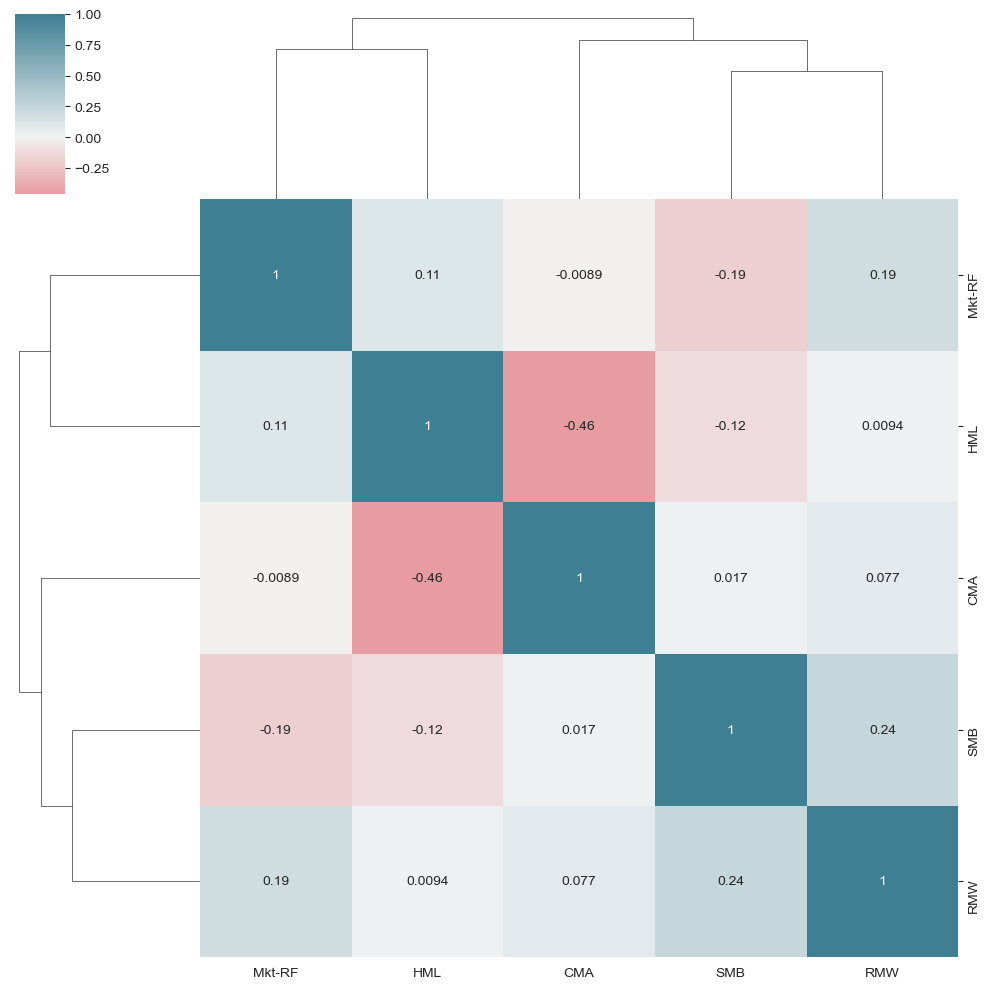

In [19]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [20]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   465935 non-null  float64
 1   return_2m   465935 non-null  float64
 2   return_3m   465935 non-null  float64
 3   return_6m   465935 non-null  float64
 4   return_9m   465935 non-null  float64
 5   return_12m  465935 non-null  float64
 6   Mkt-RF      408695 non-null  float64
 7   SMB         408695 non-null  float64
 8   HML         408695 non-null  float64
 9   RMW         408695 non-null  float64
 10  CMA         408695 non-null  float64
dtypes: float64(11)
memory usage: 57.2+ MB


### Impute mean for missing factor betas

In [21]:
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

AssertionError: Length of new_levels (3) must be <= self.nlevels (2)

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [22]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

## Date Indicators

In [23]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [24]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      465935 non-null  float64
 1   return_2m      465935 non-null  float64
 2   return_3m      465935 non-null  float64
 3   return_6m      465935 non-null  float64
 4   return_9m      465935 non-null  float64
 5   return_12m     465935 non-null  float64
 6   Mkt-RF         408695 non-null  float64
 7   SMB            408695 non-null  float64
 8   HML            408695 non-null  float64
 9   RMW            408695 non-null  float64
 10  CMA            408695 non-null  float64
 11  momentum_2     465935 non-null  float64
 12  momentum_3     465935 non-null  float64
 13  momentum_6     465935 non-null  float64
 14  momentum_9     465935 non-null  float64
 15  momentum_12    465935 non-null  float64
 16  

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [25]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [26]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.340055      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.340055  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      465935 non-null  float64
 1   return_2m      465935 non-null  float64
 2   return_3m      465935 non-null  float64
 3   return_6m      465935 non-null  float64
 4   return_9m      465935 non-null  float64
 5   return_12m     465935 non-null  float64
 6   Mkt-RF         408695 non-null  float64
 7   SMB            408695 non-null  float64
 8   HML            408695 non-null  float64
 9   RMW            408695 non-null  float64
 10  CMA            408695 non-null  float64
 11  momentum_2     465935 non-null  float64
 12  momentum_3     465935 non-null  float64
 13  momentum_6     465935 non-null  float64
 14  momentum_9     465935 non-null  float64
 15  momentum_12    465935 non-null  float64
 16  

## Create age proxy

We use quintiles of IPO year as a proxy for company age.

In [34]:
data = (data
        .join(pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data.age = data.age.fillna(-1)

## Create dynamic size proxy

We use the marketcap information from the NASDAQ ticker info to create a size proxy.

In [35]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2412 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2407 non-null   float64
 1   ipoyear    1065 non-null   float64
 2   sector     2372 non-null   object 
dtypes: float64(2), object(1)
memory usage: 139.9+ KB


Market cap information is tied to currrent prices. We create an adjustment factor to have the values reflect lower historical prices for each individual stock:

In [36]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207 entries, 2018-03-31 to 2001-01-31
Columns: 1838 entries, A to ZUMZ
dtypes: float64(1838)
memory usage: 2.9 MB


In [37]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'marketcap'])).dropna(axis=1, how='all')

### Create Size indicator as deciles per period

Compute size deciles per month:

In [38]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

## Combine data

In [39]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non

## Store data

We will use the data again in several later chapters, starting in [Chapter 7 on Linear Models](../07_linear_models).

In [41]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/assets.h5
/engineered_features                        frame        (shape->[358914,33])                                                                
/quandl/wiki/prices                         frame        (shape->[15389314,12])                                                              
/quandl/wiki/stocks                         frame        (shape->[1,2])                                                                      
/sp500/fred                                 frame        (shape->[2609,1])                                                                   
/sp500/sp500_stooq                          frame        (shape->[17700,5])                                                                  
/sp500/stocks                               frame        (shape->[1,7])                                                                      
/sp500/stooq                                frame        (shape->[17700,5])      

## Create Dummy variables

For most models, we need to encode categorical variables as 'dummies' (one-hot encoding):

In [42]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 88 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   return_1m              360752 non-null  float64
 1   return_2m              360752 non-null  float64
 2   return_3m              360752 non-null  float64
 3   return_6m              360752 non-null  float64
 4   return_9m              360752 non-null  float64
 5   return_12m             360752 non-null  float64
 6   Mkt-RF                 360752 non-null  float64
 7   SMB                    360752 non-null  float64
 8   HML                    360752 non-null  float64
 9   RMW                    360752 non-null  float64
 10  CMA                    360752 non-null  float64
 11  momentum_2             360752 non-null  float64
 12  momentum_3             360752 non-null  float64
